In [2]:
import tensorflow as tf
import simplejson
import matplotlib.pyplot as plt
%matplotlib inline
import threading
import tensorflow.contrib.slim as slim
from utils import data_utils, train_utils
import datetime
import os
import time
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

In [3]:
def argument_scope(H, phase):
    '''
    This returns the arg_scope for slim.arg_scope(), which defines the options for slim.functions
    '''
    padding = H['padding']
    is_training = {'train': True, 'validate': False, 'test': False}[phase]
    pool_kernel = [2, 2]
    pool_stride = 2

    
    params = {
        "decay": 0.997,
        "epsilon": 0.001,
    }

    with slim.arg_scope([slim.conv2d], 
                        # slim.relu would raise an error here
                        activation_fn=tf.nn.relu, 
                        padding=padding, 
                        normalizer_fn=slim.batch_norm, 
                        # normalizer_fn=None,
                        weights_initializer=tf.contrib.layers.variance_scaling_initializer()):
        with slim.arg_scope([slim.batch_norm, slim.dropout], is_training=is_training):
            with slim.arg_scope([slim.max_pool2d], stride=pool_stride, kernel_size=pool_kernel):
                with slim.arg_scope([slim.conv2d_transpose], 
                                    activation_fn=None, 
                                    normalizer_fn=None,
                                    padding=padding, 
                                    weights_initializer=tf.contrib.layers.variance_scaling_initializer()) as sc:
                    return sc

In [4]:
def build_pred(x_in, H, phase):
    '''
    This function builds the prediction model
    '''
    num_class = H['num_class']
    
    conv_kernel_1 = [1, 1]
    conv_kernel_3 = [3, 3]
    pool_kernel = [2, 2]
    pool_stride = 2

    early_feature = {}
    reuse = {'train': False, 'validate': True, 'test': False}[phase]
    
    with slim.arg_scope(argument_scope(H, phase)):
        
        scope_name = 'block_1'
        x_input = x_in
        num_outputs = 64
        with tf.variable_scope(scope_name, reuse = reuse):
            layer_1 = slim.conv2d(x_input, num_outputs, conv_kernel_3, scope='conv1')
            layer_2 = slim.conv2d(layer_1, num_outputs, conv_kernel_3, scope='conv2')
            early_feature[scope_name] = layer_2
        
        scope_name = 'block_2'
        x_input = slim.max_pool2d(layer_2)
        num_outputs = 128
        with tf.variable_scope(scope_name, reuse = reuse):
            layer_1 = slim.conv2d(x_input, num_outputs, conv_kernel_3, scope='conv1')
            layer_2 = slim.conv2d(layer_1, num_outputs, conv_kernel_3, scope='conv2')
            early_feature[scope_name] = layer_2

        scope_name = 'block_3'
        x_input = slim.max_pool2d(layer_2)
        num_outputs = 256
        with tf.variable_scope(scope_name, reuse = reuse):
            layer_1 = slim.conv2d(x_input, num_outputs, conv_kernel_3, scope='conv1')
            layer_2 = slim.conv2d(layer_1, num_outputs, conv_kernel_3, scope='conv2')
            early_feature[scope_name] = layer_2
            
        scope_name = 'block_4'
        x_input = slim.max_pool2d(layer_2)
        num_outputs = 512
        with tf.variable_scope(scope_name, reuse = reuse):
            layer_1 = slim.conv2d(x_input, num_outputs, conv_kernel_3, scope='conv1')
            layer_2 = slim.conv2d(layer_1, num_outputs, conv_kernel_3, scope='conv2')
            early_feature[scope_name] = layer_2

        scope_name = 'block_5'
        x_input = slim.max_pool2d(layer_2)
        num_outputs = 1024
        with tf.variable_scope(scope_name, reuse = reuse):
            layer_1 = slim.conv2d(x_input, num_outputs, conv_kernel_3, scope='conv1')
            layer_2 = slim.conv2d(layer_1, num_outputs, conv_kernel_3, scope='conv2')
            early_feature[scope_name] = layer_2
            
        scope_name = 'block_6'
        num_outputs = 512
        with tf.variable_scope(scope_name, reuse = reuse):
            trans_layer = slim.conv2d_transpose(
                layer_2, num_outputs, pool_kernel, pool_stride, scope='conv_trans')
            x_input = tf.concat([early_feature['block_4'], trans_layer], axis=3)
            layer_1 = slim.conv2d(x_input, num_outputs, conv_kernel_3, scope='conv1')
            layer_2 = slim.conv2d(layer_1, num_outputs, conv_kernel_3, scope='conv2')
            early_feature[scope_name] = layer_2
            
        scope_name = 'block_7'
        num_outputs = 256
        with tf.variable_scope(scope_name, reuse = reuse):
            trans_layer = slim.conv2d_transpose(
                layer_2, num_outputs, pool_kernel, pool_stride, scope='conv_trans')
            x_input = tf.concat([early_feature['block_3'], trans_layer], axis=3)
            layer_1 = slim.conv2d(x_input, num_outputs, conv_kernel_3, scope='conv1')
            layer_2 = slim.conv2d(layer_1, num_outputs, conv_kernel_3, scope='conv2')
            early_feature[scope_name] = layer_2
            
        scope_name = 'block_8'
        num_outputs = 128
        with tf.variable_scope(scope_name, reuse = reuse):
            trans_layer = slim.conv2d_transpose(
                layer_2, num_outputs, pool_kernel, pool_stride, scope='conv_trans')
            x_input = tf.concat([early_feature['block_2'], trans_layer], axis=3)
            layer_1 = slim.conv2d(x_input, num_outputs, conv_kernel_3, scope='conv1')
            layer_2 = slim.conv2d(layer_1, num_outputs, conv_kernel_3, scope='conv2')
            early_feature[scope_name] = layer_2
        
        scope_name = 'block_9'
        num_outputs = 64
        with tf.variable_scope(scope_name, reuse = reuse):
            trans_layer = slim.conv2d_transpose(
                layer_2, num_outputs, pool_kernel, pool_stride, scope='conv_trans')
            x_input = tf.concat([early_feature['block_1'], trans_layer], axis=3)
            layer_1 = slim.conv2d(x_input, num_outputs, conv_kernel_3, scope='conv1')
            layer_2 = slim.conv2d(layer_1, num_outputs, conv_kernel_3, scope='conv2')
            early_feature[scope_name] = layer_2
        
        scope_name = 'pred'
        with tf.variable_scope(scope_name, reuse = reuse):
            # layer_1 = slim.conv2d(layer_2, num_class, conv_kernel_1, scope='conv1', activation_fn=None, normalizer_fn=None)
            layer_1 = slim.conv2d(layer_2, 1, conv_kernel_1, scope='conv1', activation_fn=None, normalizer_fn=None)

            early_feature[scope_name] = layer_1
            
            # pred = tf.argmax(tf.nn.softmax(logits=layer_1), axis=3)
            pred = tf.sigmoid(layer_1)
                
        return tf.squeeze(layer_1), tf.squeeze(pred)

In [5]:
hypes = './hypes/hypes.json'
with open(hypes, 'r') as f:
    H = simplejson.load(f)

In [6]:
img_in = tf.placeholder(dtype=tf.float32, shape=[1, 3200, 3200, 16])

In [7]:
logits, pred = build_pred(img_in, H, 'test')

In [8]:
img_data = data_utils.ImageData(17)
img_data.load_image()
img_data.create_label()
img_data.create_train_feature()

In [20]:
config = tf.ConfigProto(device_count = {'GPU': 0})
saver = tf.train.Saver()
with tf.Session(config=config) as sess:
    sess.run(tf.global_variables_initializer())
    saver.restore(sess, save_path='log_dir/8-12_14-32_combo-jaccard/ckpt/ckpt-1001')
    predictions, log = sess.run([pred, logits], 
                                feed_dict = {img_in: np.reshape(img_data.train_feature[:3200, :3200, :], 
                                                                [1, 3200, 3200, 16])})

INFO:tensorflow:Restoring parameters from log_dir/8-12_14-32_combo-jaccard/ckpt/ckpt-1001


In [21]:
img_data.train_feature.shape

(3348, 3403, 16)

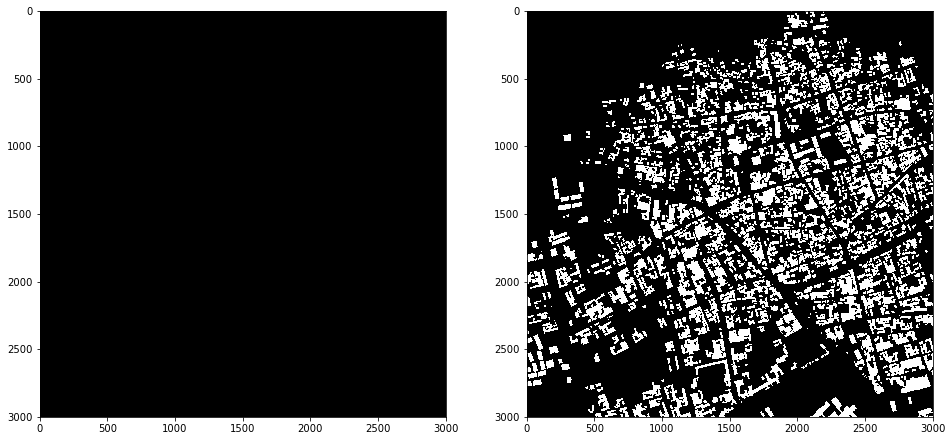

In [33]:
fig, axs = plt.subplots(1,2, figsize = [16, 8])
axs[0].imshow((predictions > 0.5).astype(int)[0: 3000, 0: 3000], cmap = matplotlib.cm.gray)
axs[1].imshow(img_data.label[0: 3000, 0: 3000, 0], cmap = matplotlib.cm.gray)

In [34]:
np.mean(predictions), np.std(predictions)

(1.0, 0.0)

In [35]:
np.mean(log), np.std(log)

(391.72754, 50.709972)

In [ ]:
fig, axs = plt.subplots(1,2, figsize = [16, 8])
axs[0].imshow((predictions > 0.8).astype(int)[0: 3000, 0: 3000], cmap = matplotlib.cm.gray)
axs[1].imshow(img_data.label[0: 3000, 0: 3000, 0], cmap = matplotlib.cm.gray)

In [ ]:
fig, axs = plt.subplots(figsize = [20, 20])
axs.imshow(img_data.label[0: 3000, 0: 3000, 0], cmap = matplotlib.cm.gray)

In [ ]:
np.mean(predictions), np.std(predictions)

In [ ]:
data_utils.image_IDs_dict

In [ ]:
predictions

In [ ]:
predictions[:20,:20]

In [18]:
train_utils.test_ids

[13, 14, 10, 17]

In [27]:
reload(train_utils)

<module 'utils.train_utils' from 'utils/train_utils.py'>

In [32]:
for i in range(10): print sorted(train_utils.generate_train_ids(i))

[7, 8, 11, 12, 15, 16, 18, 19]
[0, 7, 8, 9, 11, 12, 15, 16, 18, 19, 20, 22, 23]
[8, 11, 12, 15, 16, 18, 19]
[0, 1, 3, 4, 5, 6, 7, 9, 11, 12, 15, 16, 18, 19, 20, 21, 22, 23, 24]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 12, 15, 16, 18, 19, 20, 21, 22, 23, 24]
[4, 7, 9, 11, 15, 16, 18, 19, 20, 23]
[8, 11]
[8, 9, 11, 12, 15, 18, 19, 22, 23]
[11, 12, 15, 16, 19]
[7, 8, 9, 11, 12, 15, 16, 18, 19]


In [29]:
train_utils.test_ids

[13, 14, 10, 17]